In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from procedures import create_binance_bot, create_binance_bot_spot, make_get_filepath
from pure_funcs import get_template_live_config, ts_to_date, get_daily_from_income
from njit_funcs import round_dynamic
from time import time, sleep
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

using numba


In [3]:
plt.rcParams["figure.figsize"] = [21, 13]
pd.set_option("display.precision", 10)

In [4]:
config = get_template_live_config()
config["symbol"] = "XMRUSDT"  # dummy symbol
config["exchange"] = "binance"
config["market_type"] = "futures"
config["user"] = "binance_01"
try:
    await bot.session.close()
except:
    pass
if config["market_type"] == "spot":
    bot = await create_binance_bot_spot(config)
else:
    bot = await create_binance_bot(config)

linear perpetual


In [5]:
info = await bot.public_get(bot.endpoints["exchange_info"])
symbols = [e["symbol"] for e in info["symbols"] if e["symbol"].endswith("USDT")]

interval = "5m"

fpath = f"logs/binance/ohlcvs_{interval}/"
if os.path.exists(fpath):
    print("loading cache")
    csvs = {}
    for f in [x for x in os.listdir(fpath) if x.endswith(".csv")]:
        csvs[f[:-4]] = pd.read_csv(fpath + f)
else:
    fpath = make_get_filepath(f"logs/binance/ohlcvs_{interval}/")

    data = {}
    for s in sorted(symbols):
        print(s, end=" ")
        ohlcvs = await bot.fetch_ohlcvs(symbol=s, interval=interval)
        data[s] = ohlcvs
        sleep(0.5)
    # cache as csv for later use
    csvs = {}
    fpath = make_get_filepath(f"logs/binance/ohlcvs_{interval}/")
    for s in data:
        csvs[s] = pd.DataFrame(data[s])
        csvs[s].to_csv(f"{fpath}{s}.csv")
n_days = (
    (csvs[symbols[0]].timestamp.iloc[-1] - csvs[symbols[0]].timestamp.iloc[0]) / 1000 / 60 / 60 / 24
)
print("n days", n_days)

1000BTTCUSDT 1000SHIBUSDT 1000XECUSDT 1INCHUSDT AAVEUSDT ADAUSDT AKROUSDT ALGOUSDT ALICEUSDT ALPHAUSDT ANKRUSDT ANTUSDT ARPAUSDT ARUSDT ATAUSDT ATOMUSDT AUDIOUSDT AVAXUSDT AXSUSDT BAKEUSDT BALUSDT BANDUSDT BATUSDT BCHUSDT BELUSDT BLZUSDT BNBUSDT BTCDOMUSDT BTCSTUSDT BTCUSDT BTSUSDT C98USDT CELOUSDT CELRUSDT CHRUSDT CHZUSDT COMPUSDT COTIUSDT CRVUSDT CTKUSDT CTSIUSDT CVCUSDT DASHUSDT DEFIUSDT DENTUSDT DGBUSDT DODOUSDT DOGEUSDT DOTUSDT DUSKUSDT DYDXUSDT EGLDUSDT ENJUSDT ENSUSDT EOSUSDT ETCUSDT ETHUSDT FILUSDT FLMUSDT FTMUSDT GALAUSDT GRTUSDT GTCUSDT HBARUSDT HNTUSDT HOTUSDT ICPUSDT ICXUSDT IOSTUSDT IOTAUSDT IOTXUSDT KAVAUSDT KEEPUSDT KLAYUSDT KNCUSDT KSMUSDT LINAUSDT LINKUSDT LITUSDT LPTUSDT LRCUSDT LTCUSDT LUNAUSDT MANAUSDT MASKUSDT MATICUSDT MKRUSDT MTLUSDT NEARUSDT NEOUSDT NKNUSDT NUUSDT OCEANUSDT OGNUSDT OMGUSDT ONEUSDT ONTUSDT PEOPLEUSDT QTUMUSDT RAYUSDT REEFUSDT RENUSDT RLCUSDT ROSEUSDT RSRUSDT RUNEUSDT RVNUSDT SANDUSDT SCUSDT SFPUSDT SKLUSDT SNXUSDT SOLUSDT SRMUSDT STMXUSDT STORJUS

In [6]:
def correlation(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    a = x - x_mean
    b = y - y_mean
    return ((a * b).sum()) / (((a ** 2).sum() * (b ** 2).sum()) ** 0.5)

In [7]:
n_symbols = 30
vols = [(csvs[s].volume * csvs[s].close).sum() for s in csvs]
minvol = sorted(vols)[-n_symbols]
ss = [s for s in csvs if (csvs[s].volume * csvs[s].close).sum() >= minvol]
corrs = []
corrs_dict = {}
done = set()
for s0 in sorted(ss):
    for s1 in sorted(ss):
        if s0 == s1:
            continue
        key = tuple(sorted([s0, s1]))
        if key in done:
            continue
        done.add(key)
        x = csvs[s0].close
        y = csvs[s1].close
        corr = correlation(x, y)
        print(f"\r{s0} {s1} {corr:.4f}      ", end=" ")
        corrs.append((corr,) + key)

corrs_dict = {}
corrs_dict_abs = {}
for e in corrs:
    if e[1] not in corrs_dict:
        corrs_dict[e[1]] = {e[2]: e[0]}
        corrs_dict_abs[e[1]] = {e[2]: abs(e[0])}

    else:
        corrs_dict[e[1]][e[2]] = e[0]
        corrs_dict_abs[e[1]][e[2]] = abs(e[0])

    if e[2] not in corrs_dict:
        corrs_dict[e[2]] = {e[1]: e[0]}
        corrs_dict_abs[e[2]] = {e[1]: abs(e[0])}

    else:
        corrs_dict[e[2]][e[1]] = e[0]
        corrs_dict_abs[e[2]][e[1]] = abs(e[0])

WAVESUSDT XRPUSDT 0.6055                

In [8]:
# sum correlation of each symbol to every other symbol
sorted([(sum(corrs_dict[s].values()), s) for s in corrs_dict])

[(1.4947512851555536, 'LUNAUSDT'),
 (1.9318381711034562, 'ATOMUSDT'),
 (3.108024951602819, 'THETAUSDT'),
 (6.213425753861619, 'PEOPLEUSDT'),
 (7.821387659252649, 'SANDUSDT'),
 (8.39697543746729, 'FTMUSDT'),
 (9.612941248339984, 'WAVESUSDT'),
 (10.760198573937332, 'SUSHIUSDT'),
 (11.127558401117822, 'MANAUSDT'),
 (11.797387485244966, 'LRCUSDT'),
 (12.134987426530552, 'MATICUSDT'),
 (12.523443698528096, 'BNBUSDT'),
 (12.850283242268572, 'ICPUSDT'),
 (12.955783077466732, 'AXSUSDT'),
 (13.204522513433151, 'GALAUSDT'),
 (14.031133876402448, 'DYDXUSDT'),
 (14.108517590469422, 'NEARUSDT'),
 (15.913007400440668, 'LINKUSDT'),
 (16.206049335526743, 'DOGEUSDT'),
 (16.65264083925292, 'ONEUSDT'),
 (16.973591015029577, 'BTCUSDT'),
 (17.103183738529278, 'ADAUSDT'),
 (17.50205600327039, 'ETHUSDT'),
 (17.55544689598484, 'AVAXUSDT'),
 (17.999206066312205, 'LTCUSDT'),
 (18.005772269522627, 'CRVUSDT'),
 (18.262728690032862, '1000SHIBUSDT'),
 (18.362932031609493, 'DOTUSDT'),
 (18.363380458278918, 'XRPUSDT'

In [9]:
# sum abs correlation of each symbol to every other symbol
sorted([(sum(corrs_dict_abs[s].values()), s) for s in corrs_dict])

[(10.981441186363938, 'THETAUSDT'),
 (11.412998895985686, 'WAVESUSDT'),
 (11.525154053157932, 'LUNAUSDT'),
 (11.694860167998092, 'ATOMUSDT'),
 (11.708158588210242, 'PEOPLEUSDT'),
 (12.007909885607154, 'LRCUSDT'),
 (13.204522513433151, 'GALAUSDT'),
 (13.24281912232643, 'SANDUSDT'),
 (13.480693298171575, 'ICPUSDT'),
 (13.646729393638198, 'FTMUSDT'),
 (14.127300063809765, 'BNBUSDT'),
 (14.333921517055584, 'AXSUSDT'),
 (14.382298508568406, 'DYDXUSDT'),
 (14.42683161248163, 'SUSHIUSDT'),
 (14.864253560107551, 'MANAUSDT'),
 (15.04573092180435, 'NEARUSDT'),
 (15.662351870350419, 'MATICUSDT'),
 (16.206049335526743, 'DOGEUSDT'),
 (16.937196586964934, 'LINKUSDT'),
 (17.070719537627966, 'ONEUSDT'),
 (17.103183738529278, 'ADAUSDT'),
 (17.969180904544185, 'BTCUSDT'),
 (17.993922979171693, 'AVAXUSDT'),
 (17.999206066312205, 'LTCUSDT'),
 (18.099018968826787, 'CRVUSDT'),
 (18.262728690032862, '1000SHIBUSDT'),
 (18.314832712770524, 'ETHUSDT'),
 (18.362932031609493, 'DOTUSDT'),
 (18.363380458278918, 'XR

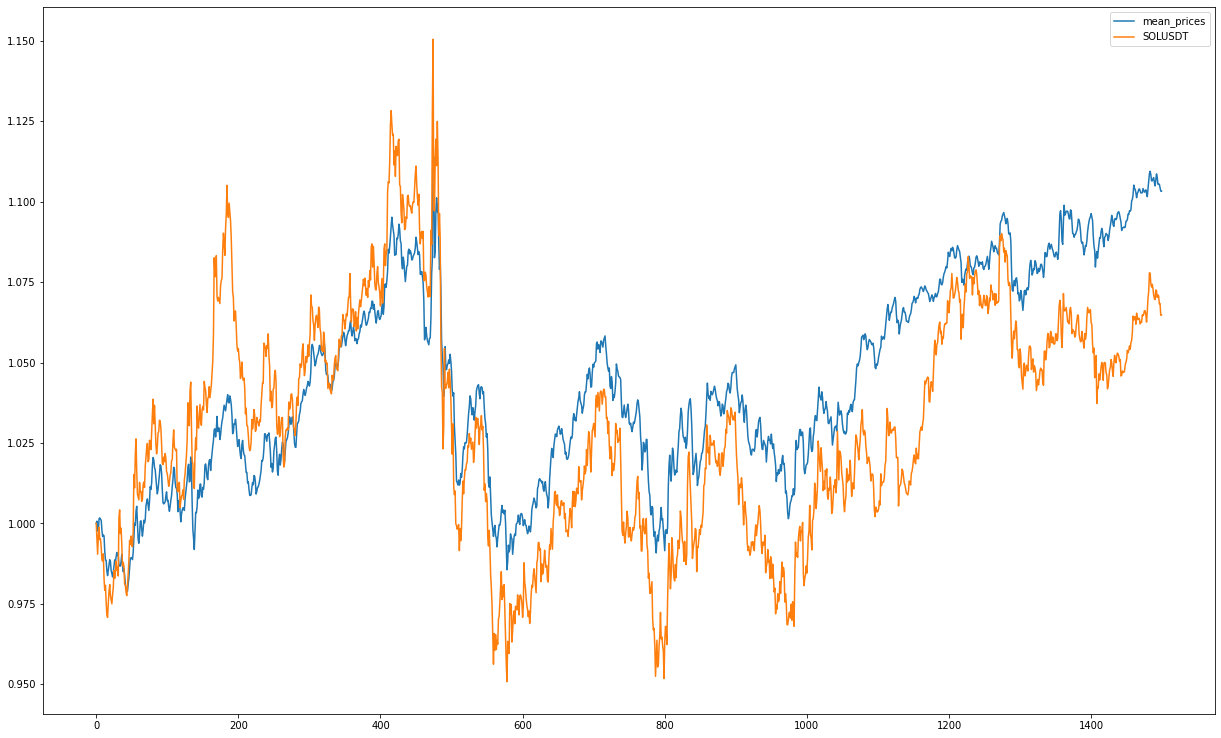

In [10]:
# mean of all symbol
mean_prices = pd.concat([e.close / e.close.iloc[0] for e in csvs.values()], axis=1).mean(axis=1)

# compare individual symbol to mean
symbol = "SOLUSDT"
mean_prices.rename("mean_prices").plot()
(csvs[symbol].close / csvs[symbol].close.iloc[0]).rename(symbol).plot()
plt.legend()

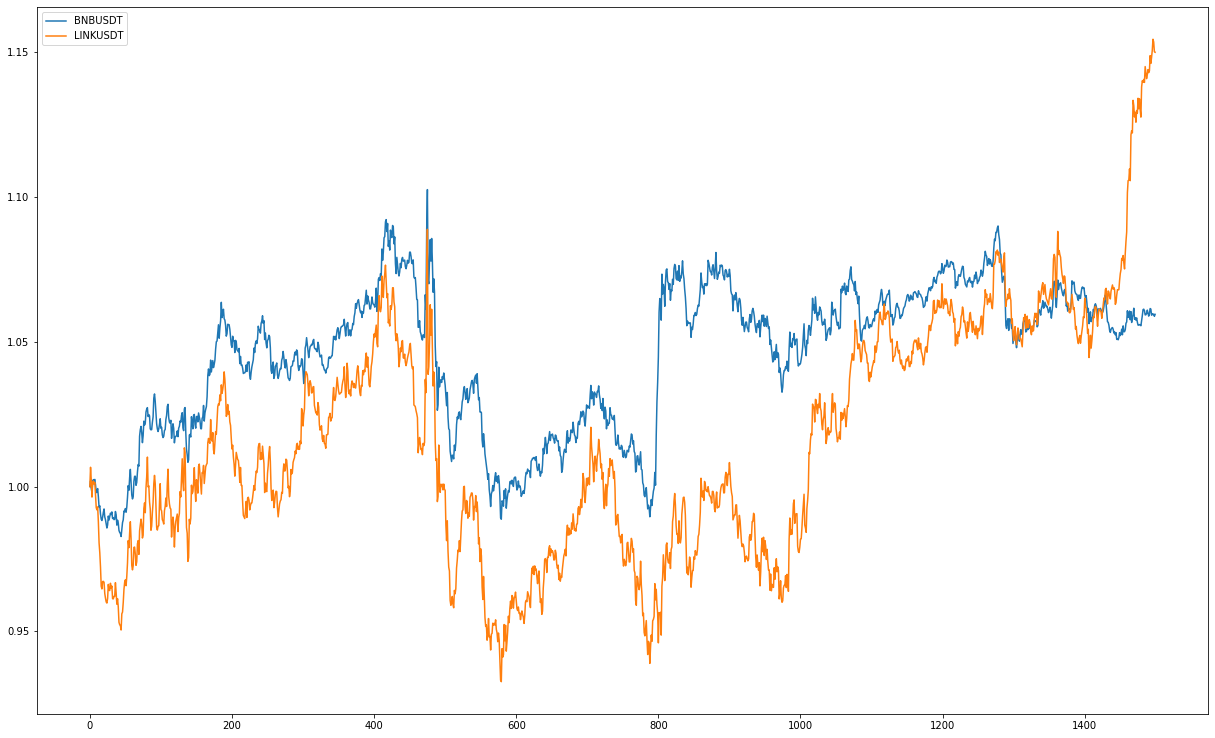

In [11]:
# compare two symbols
symbol0 = "BNBUSDT"
symbol1 = "LINKUSDT"
(csvs[symbol0].close / csvs[symbol0].close.iloc[0]).rename(symbol0).plot()
(csvs[symbol1].close / csvs[symbol1].close.iloc[0]).rename(symbol1).plot()
plt.legend()